In [1]:
import torch
from torch.nn import functional as F
from torch import nn
import einops
import comet_ml
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Set default tensor type for cuda
        torch.set_default_dtype(torch.float32)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        # Ensure we're using float32 on CPU

        torch.set_default_dtype(torch.float64)
    return device

device = setup_device()

print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


Using cuda device


In [3]:
# !pip install datasets
from datasets import load_dataset

#maskę uszkodzeń dodawać jako 4 kanał, przy in-paintingu

full_dataset = load_dataset("Artificio/WikiArt_Full").with_format("torch")


full_dataset=full_dataset['train']


train_test_split = full_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

test_val_split = test_dataset.train_test_split(test_size=0.5)
test_dataset = test_val_split['train']
val_dataset = test_val_split['test']


# Resnet 101


In [ ]:
#Autoencoder definition
from torchvision import models
class Encoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels:int,out_channels:int):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(True)
    )
  def __init__(self,latent_dim:int=32768) -> None:
    super().__init__()
    self.latent_dim=latent_dim
    resnet101 = models.resnet101(pretrained=True)
    self.model = nn.Sequential(
        *list(resnet101.children())[:-2],
        nn.Conv2d(2048,52,kernel_size=1,stride=1,padding=0)
        )

    # vgg16 = models.vgg16(pretrained=True)
    #resnet
    # self.model = vgg16.features
    # self.model=nn.Sequential(
    #     #Block 1
    #     Encoder.ConvBlock(3,64),
    #     Encoder.ConvBlock(64,64),
    #     nn.MaxPool2d(kernel_size=2,stride=2),
    #     #Block 2
    #     Encoder.ConvBlock(64,128),
    #     Encoder.ConvBlock(128,128),
    #     nn.MaxPool2d(kernel_size=2,stride=2),
    #     #Block 3
    #     Encoder.ConvBlock(128,256),
    #     Encoder.ConvBlock(256,256),
    #     Encoder.ConvBlock(256,256),
    #     nn.MaxPool2d(kernel_size=2,stride=2),

    #     #Block 4
    #     Encoder.ConvBlock(256,512),
    #     Encoder.ConvBlock(512,512),
    #     Encoder.ConvBlock(512,512),

    #     nn.MaxPool2d(kernel_size=2,stride=2),

    #     #Block 5
    #     Encoder.ConvBlock(512,512),
    #     Encoder.ConvBlock(512,512),
    #     Encoder.ConvBlock(512,512),
    #     nn.MaxPool2d(kernel_size=2,stride=2),

    # )
    # self.fc=nn.Sequential(
    #     nn.Linear(16*256*256,self.latent_dim),
    #     nn.Tanh()
    #     )
  def forward(self,x):
    x=self.model(x)
    # x=einops.rearrange(x,'b c h w -> b (c h w)')
    # x=self.fc(x)
    return x
class Decoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels:int,out_channels:int,activation=True):
    if activation:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
          # nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
          nn.BatchNorm2d(out_channels)
      )

  def __init__(self,latent_dim:int=32768) -> None:
    super().__init__()
    self.latent_dim=latent_dim
    self.model=nn.Sequential(

            nn.Conv2d(52,2048,kernel_size=1,stride=1,padding=0),

            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(2048,1024),
            Decoder.ConvBlock(1024,512),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(512,256),
            Decoder.ConvBlock(256,128),

            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(128,64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(64,64),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64,3,kernel_size=3,stride=1,padding=1),

            nn.Sigmoid()
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # Decoder.ConvBlock(512, 512),
            # Decoder.ConvBlock(512, 512),
            # Decoder.ConvBlock(512, 512),

            # nn.Upsample(scale_factor=2, mode='nearest'),
            # Decoder.ConvBlock(512, 512),
            # Decoder.ConvBlock(512, 256),
            # Decoder.ConvBlock(256, 256),

            # nn.Upsample(scale_factor=2, mode='nearest'),
            # Decoder.ConvBlock(256, 128),
            # Decoder.ConvBlock(128, 128),

            # nn.Upsample(scale_factor=4, mode='nearest'),
            # Decoder.ConvBlock(128, 64),
            # nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

            # Decoder.ConvBlock(64, 3),

            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.Sigmoid()
    )
    # self.fc=nn.Sequential(
    #     nn.Linear(2,512*8*8),
    #     nn.Tanh()
    #     )
  def forward(self,x):
    # x=self.fc(x)
    # x=einops.rearrange(x,'b (c h w) -> b c h w ',c=512,w=8,h=8)
    x=self.model(x)
    return x
class ArtAutoEncoder(nn.Module):

    def __init__(self, latent_dim=32768):
      #Latent raczej koło 2000
        super(ArtAutoEncoder, self).__init__()

        self.encoder=Encoder()
        # self.fc_mu=nn.Linear(latent_dim,2)
        # self.fc_logvar=nn.Linear(latent_dim,2)

        self.decoder=Decoder()
    def reparameterization(self, mu, logvar):
          eps = torch.randn_like(logvar).to(device)
          return mu + eps * logvar
    def forward(self, x):
        x = self.encoder(x)
        # mu = self.fc_mu(x)
        # logvar = self.fc_logvar(x)
        # x = self.reparameterization(mu,logvar)
        x = self.decoder(x)
        return x#,mu,logvar

# Resnet34


In [4]:
#Autoencoder definition
from torchvision import models
class Encoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels:int,out_channels:int):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(True)
    )
  def __init__(self,latent_dim:int=32768) -> None:
    super().__init__()
    self.latent_dim=latent_dim
    resnet34 = models.resnet34(pretrained=True)
    self.model = nn.Sequential(
        *list(resnet34.children())[:-2],
        nn.Conv2d(512,52,kernel_size=1,stride=1,padding=0)
        )
  def forward(self,x):
    x=self.model(x)
    return x
class Decoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels:int,out_channels:int):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )
  def __init__(self,latent_dim:int=32768) -> None:
    super().__init__()
    self.latent_dim=latent_dim
    self.model=nn.Sequential(
            nn.Conv2d(52,512,kernel_size=1,stride=1,padding=0),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(512,256),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(256,128),

            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(128,64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            Decoder.ConvBlock(64,64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64,3,kernel_size=3,stride=1,padding=1),

            nn.Sigmoid()
    )

  def forward(self,x):
    x=self.model(x)
    return x
class ArtAutoEncoder(nn.Module):

    def __init__(self):
      #Latent raczej koło 2000 (aktualnie 52*7*7)
        super(ArtAutoEncoder, self).__init__()

        self.encoder=Encoder()


        self.decoder=Decoder()
    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x

In [5]:
model=ArtAutoEncoder().to(device)
name="resnet34_autoencoder"
model.load_state_dict(torch.load(f"{name}.pth",map_location=device))
model=model.float()

c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\peter\AppData\Local\Temp\ipykernel_15692\4135884391.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def train_vae(model, train_loader,val_loader,experiment,name="autoencoder", num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    with experiment.train():
      for epoch in range(num_epochs):
          model.train()
          train_loss=0
          i=0
          for batch in train_loader:
              i+=1
              x = batch['image'].to(device)
              x= x.float()/255.0
              # x=transform(x) #Z rrasnformami działało gorzej

              x_recon = model(x)


              loss = nn.functional.mse_loss(x_recon, x, reduction='sum')


              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              experiment.log_metric(f"batch_loss_{epoch}",loss.item(),step=i)
              train_loss+=loss.item()

              if i%15==0:
                print(f"Epoch {epoch + 1}, Batches {i}, Loss: {loss.item():.4f}")
                torch.save(model.state_dict(),f"/content/drive/My Drive/{name}.pth")

          train_loss=train_loss/len(train_loader)
          print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")
          experiment.log_metric("epoch_loss",train_loss,step=epoch)
          torch.save(model.state_dict(),f"/content/drive/My Drive/{name}.pth")

          with experiment.validate():
            model.eval()
            with torch.no_grad():
              val_loss=0
              for batch in val_loader:
                x = batch['image'].to(device)
                x=x.float()/255.0
                # x=transform(x)

                x_recon = model(x)

                loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
                val_loss+=loss.item()

            experiment.log_metric("val_loss",val_loss/len(val_loader),step=epoch)

def test_vae(model,test_loader,experiment):
          with experiment.test():
            model.eval()
            with torch.no_grad():
              test_loss=0
              for batch in test_loader:
                x = batch['image'].to(device)
                x=x.float()/255.0
                x_recon = model(x)
                # x=transform(x)

                loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
                test_loss+=loss.item()
            experiment.log_metric("test_loss",test_loss/len(test_loader))

batch_size = 32

enable_pin_memory = True

number_of_workers = 2 # for colab


train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)


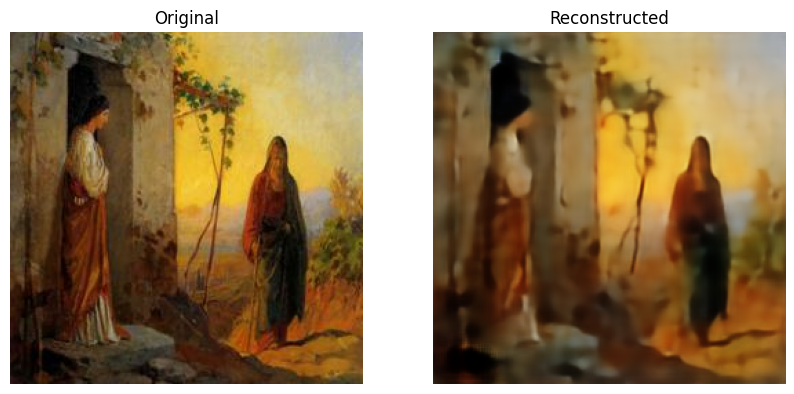

In [7]:
batch=next(iter(test_loader))
img=batch['image'][0]
model.eval()
test_img=None
with torch.no_grad():
  x = batch['image'].to(device)
  x=x.float()/255.0
  test_img = model(x)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(img.permute(1,2,0).numpy())
axes[0].axis('off')  # Hide axis
axes[0].set_title('Original')

# Plot the second image
axes[1].imshow(test_img[0].permute(1,2,0).cpu().numpy())
axes[1].axis('off')  # Hide axis
axes[1].set_title('Reconstructed')

# Show the plot
plt.plot()
plt.show()

In [ ]:
def print_parameter_details(model):

    print(f"Model device: {next(model.parameters()).device}")

    # Print model summary
    print("Model summary: ")
    print(model)

    print("\nDetailed parameter information:")
    for name, param in model.named_parameters():
        print(f"{name}:")
        print(f"  Shape: {param.shape}")
        print(f"  Parameters: {param.numel()}")
        print(f"  Trainable: {param.requires_grad}")

    total_params = sum(param.numel() for param in model.parameters() )
    print(f"Total parameters: {total_params}")

    # Calculate the number of trainable parameters
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # https://wandb.ai/wandb_fc/tips/reports/How-To-Calculate-Number-of-Model-Parameters-for-PyTorch-and-TensorFlow-Models--VmlldzoyMDYyNzIx
    print(f"Total trainable parameters: {total_trainable_params}")



In [ ]:
import comet_ml
from comet_ml.integration.pytorch import watch

from google.colab import userdata
experiment=comet_ml.start(userdata.get('COMET_API_KEY'))
name="resnet34_autoencoder"
experiment.set_name(name+"_3")

model=ArtAutoEncoder().to(device)
# print_parameter_details(model)
model.load_state_dict(torch.load(f"/content/drive/My Drive/{name}.pth"))
watch(model)
train_vae(model,train_loader,val_loader,experiment,name,num_epochs=5)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/elpolaco/general/86181026e0b3419580976e449a1a49a6

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
<ipython-input-21-5d4b6dd8c6bd>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped

Epoch 1, Batches 15, Loss: 26254.4961
Epoch 1, Batches 30, Loss: 21130.1289
Epoch 1, Batches 45, Loss: 28790.8750
Epoch 1, Batches 60, Loss: 26485.3711
Epoch 1, Batches 75, Loss: 32285.8027
Epoch 1, Batches 90, Loss: 27065.2656
Epoch 1, Batches 105, Loss: 31280.1738
Epoch 1, Batches 120, Loss: 28838.8789
Epoch 1, Batches 135, Loss: 21555.9746
Epoch 1, Batches 150, Loss: 26185.6719
Epoch 1, Batches 165, Loss: 26315.8496
Epoch 1, Batches 180, Loss: 28901.1133
Epoch 1, Batches 195, Loss: 25373.7656
Epoch 1, Batches 210, Loss: 24400.9902
Epoch 1, Batches 225, Loss: 25105.9082
Epoch 1, Batches 240, Loss: 37542.3984
Epoch 1, Batches 255, Loss: 30470.8594
Epoch 1, Batches 270, Loss: 26215.2402
Epoch 1, Batches 285, Loss: 19444.0156
Epoch 1, Batches 300, Loss: 31905.6641
Epoch 1, Batches 315, Loss: 23234.3047
Epoch 1, Batches 330, Loss: 35041.8594
Epoch 1, Batches 345, Loss: 16337.7617
Epoch 1, Batches 360, Loss: 26771.5742
Epoch 1, Batches 375, Loss: 26727.4062
Epoch 1, Batches 390, Loss: 233

In [ ]:
test_vae(model,test_loader,experiment)
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : resnet34_autoencoder_3
COMET INFO:     url                   : https://www.comet.com/elpolaco/general/86181026e0b3419580976e449a1a49a6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_test_loss            : 32099.092752273606
COMET INFO:     train_batch_loss_0 [2582] : (6142.7919921875, 49622.57421875)
COMET INFO:     train_batch_loss_1 [2582] : (10993.880859375, 52888.921875)
COMET INFO:     train_batch_loss_2 [2582] : (10127.17578125, 163094.46875)
COMET INFO:     train_batch_loss_3 [2582] : (6477.05078125, 49700.07421875)
COMET INFO:     train_batch_loss_4 [2582] : (11650.134765625, 43866.3828125)
COMET INFO:     train_epoch_loss [5]

In [ ]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : resnet34_autoencoder_3
COMET INFO:     url                   : https://www.comet.com/elpolaco/general/b517ddc963e541b383f6992f7ce99cff
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_batch_loss_0 [3451] : (4285.734375, 8524792.0)
COMET INFO:     train_batch_loss_1 [3]    : (20447.787109375, 38010.9296875)
COMET INFO:     train_epoch_loss          : 25534.500452728626
COMET INFO:     validate_val_loss         : 26715.79509723297
COMET INFO:   Others:
COMET INFO:     Name         : resnet34_autoencoder_3
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1KNos0j9zQ5Zs5ZoB_POjxoIactp_dOSP
COMET INFO:   Uploa